<a href="https://colab.research.google.com/github/mehedils/ColabCodeRandom/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Downloading the dataset

In [3]:
#!/bin/bash
!curl -L -o plantvillage-tomato-leaf-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/charuchaudhry/plantvillage-tomato-leaf-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  443M  100  443M    0     0  37.7M      0  0:00:11  0:00:11 --:--:-- 41.9M


In [4]:
!unzip -qq plantvillage-tomato-leaf-dataset.zip -y
!ls

caution: filename not matched:  -y
plantvillage  plantvillage-tomato-leaf-dataset.zip  sample_data


In [5]:
!rm -rf ./plantvillage/plantvillage/

# Preprocessing data

In [6]:
BASE_DIR = "plantvillage"
BATCH_SIZE = 64
IMG_SIZE = 64
CHANNELS = 3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIR,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 14529 files belonging to 10 classes.


In [8]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

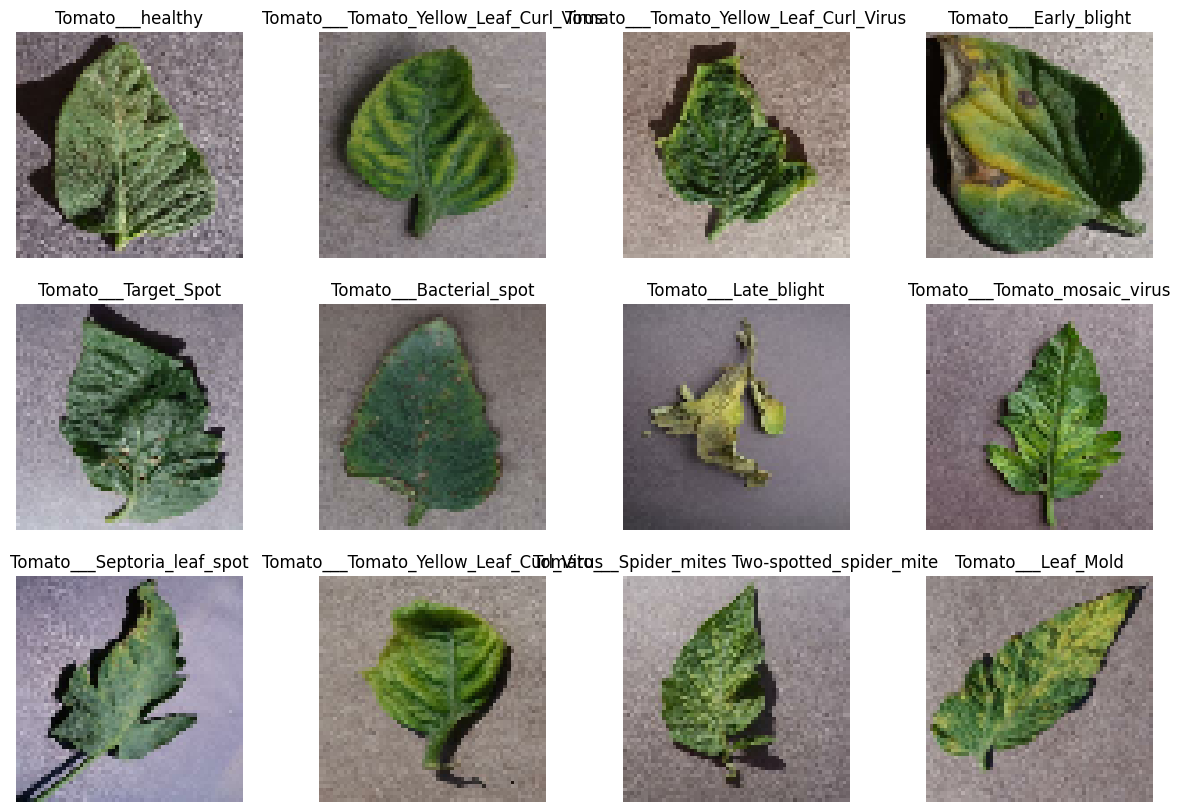

In [9]:
plt.figure(figsize=(15, 10))

for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [10]:
def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  dataset_size = len(dataset)
  if shuffle:
    dataset = dataset.shuffle(shuffle_size)
  train_size = int(train_split * dataset_size)
  val_size = int(val_split * dataset_size)

  train_dataset = dataset.take(train_size)
  val_dataset = dataset.skip(train_size).take(val_size)
  test_dataset = dataset.skip(train_size).skip(val_size)

  return train_dataset, val_dataset, test_dataset

In [11]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [12]:
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])



In [14]:
base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
)

base_model.trainable = False


# Create the custom model

In [15]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # or tf.keras.layers.Flatten()
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Optional: helps prevent overfitting
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Optional: helps prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # Final output layer for 10 classes
])

In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # this is for categorial(important to remeber)
    metrics=['accuracy']

)

In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 2, 2, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,872,778 (167.36 MB)

 Trainable params: 1,214,602 (4.63 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [18]:
epoches = 25
history = model.fit(
    train_ds,
    epochs=epoches,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - accuracy: 0.4629 - loss: 1.8220 - val_accuracy: 0.7926 - val_loss: 0.6603
Epoch 2/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7260 - loss: 0.8308 - val_accuracy: 0.8466 - val_loss: 0.4792
Epoch 3/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7692 - loss: 0.6950 - val_accuracy: 0.8800 - val_loss: 0.3884
Epoch 4/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8023 - loss: 0.5929 - val_accuracy: 0.8835 - val_loss: 0.3524
Epoch 5/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8205 - loss: 0.5247 - val_accuracy: 0.9062 - val_loss: 0.3196
Epoch 6/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8410 - loss: 0.4764 - val_accuracy: 0.9112 - val_loss: 0.2864
Epoch 7/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8452 - loss: 0.4463 - val_accuracy: 0.9148 - val_loss: 0.2683
Epoch 8/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8596 - loss: 0.4037 - val_ac

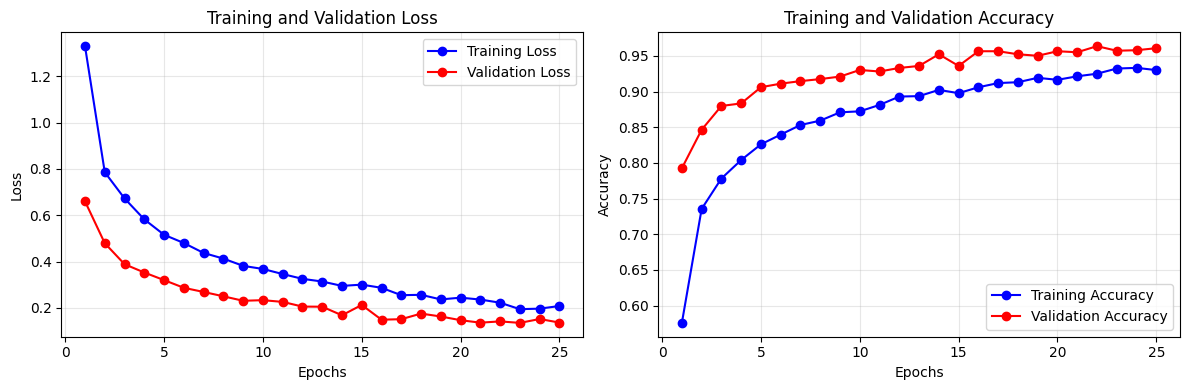

In [19]:
import matplotlib.pyplot as plt

# Get metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create the plots
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
test_results = model.evaluate(test_ds, verbose=1)

print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9681 - loss: 0.1238
Test Loss: 0.1127
Test Accuracy: 0.9701


In [21]:
import seaborn as sns

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step


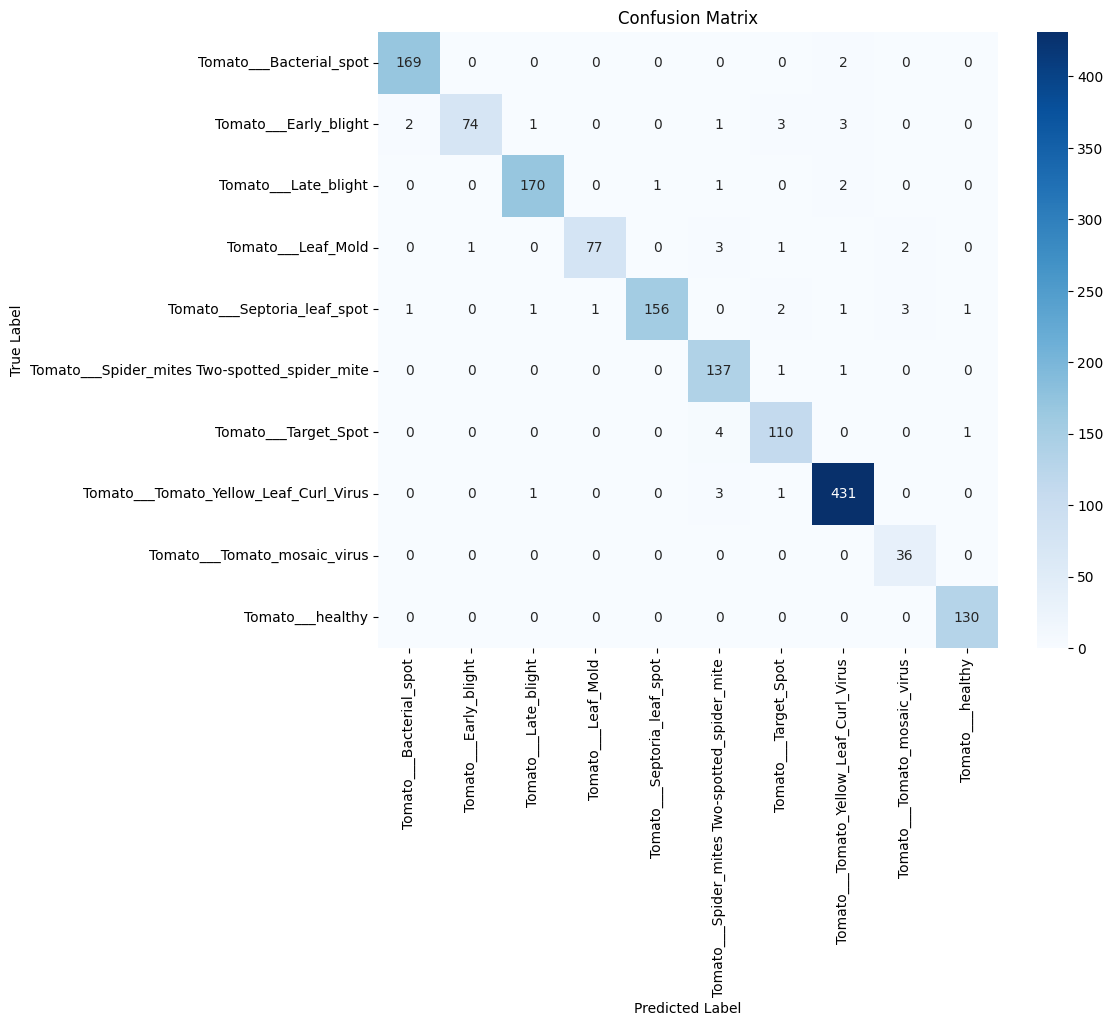

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get true labels and predictions for the test dataset
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
test_predictions = np.argmax(model.predict(test_ds), axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, test_predictions, target_names=class_names)

print("Classification Report:\n", report)

Classification Report:
                                                precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.98      0.99      0.99       171
                        Tomato___Early_blight       0.99      0.88      0.93        84
                         Tomato___Late_blight       0.98      0.98      0.98       174
                           Tomato___Leaf_Mold       0.99      0.91      0.94        85
                  Tomato___Septoria_leaf_spot       0.99      0.94      0.97       166
Tomato___Spider_mites Two-spotted_spider_mite       0.92      0.99      0.95       139
                         Tomato___Target_Spot       0.93      0.96      0.94       115
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.99      0.98       436
                 Tomato___Tomato_mosaic_virus       0.88      1.00      0.94        36
                             Tomato___healthy       0.98      1.00      0.99       130

                 

# Task
Use LIME explainer for the model.

## Install lime

### Subtask:
Install the necessary library.


**Reasoning**:
The subtask is to install the `lime` library. This can be done using pip in a code cell.



In [24]:
!pip install lime

## Prepare data for lime

### Subtask:
Create a function to preprocess images for LIME.


**Reasoning**:
Define a function to preprocess images for LIME by applying the defined resizing and rescaling layers.



In [25]:
def preprocess_image_for_lime(image_tensor):
    """
    Preprocesses an image tensor for use with LIME explainer.

    Args:
        image_tensor: A TensorFlow image tensor.

    Returns:
        A preprocessed TensorFlow image tensor.
    """
    # Apply the defined resizing and rescaling layers
    processed_image = resize_and_rescale(image_tensor)
    return processed_image

## Initialize limeimageexplainer

### Subtask:
Create an instance of the LIME explainer.


**Reasoning**:
Import the `LimeImageExplainer` and instantiate it.



In [26]:
from lime.lime_image import LimeImageExplainer

explainer = LimeImageExplainer()

## Select an image to explain

### Subtask:
Choose an image from the test dataset to explain using LIME.


**Reasoning**:
Extract a batch from the test dataset and select a single image and its label.



In [27]:
import random

# Convert the test dataset to a list to be able to select randomly
# Note: This loads the entire test dataset into memory, which might be an issue for very large datasets.
# For this dataset size, it should be acceptable.
test_images = []
test_labels_list = []
for image_batch, label_batch in test_ds:
    test_images.extend(image_batch.numpy())
    test_labels_list.extend(label_batch.numpy())

# Select a random index
random_index = random.randint(0, len(test_images) - 1)

# Get the randomly selected image and its true label
image_to_explain = test_images[random_index]
true_label = test_labels_list[random_index]

print(f"Shape of the selected image: {image_to_explain.shape}")
print(f"True label of the selected image: {true_label}")

Shape of the selected image: (64, 64, 3)
True label of the selected image: 0


In [28]:
def predict_fn(images):
    """
    Prediction function for LIME explainer.

    Args:
        images: A numpy array of images.

    Returns:
        A numpy array of prediction probabilities.
    """
    # Preprocess the images
    processed_images = np.array([preprocess_image_for_lime(img) for img in images])
    # Make predictions
    return model.predict(processed_images)

# Generate the explanation
explanation = explainer.explain_instance(
    image_to_explain,
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

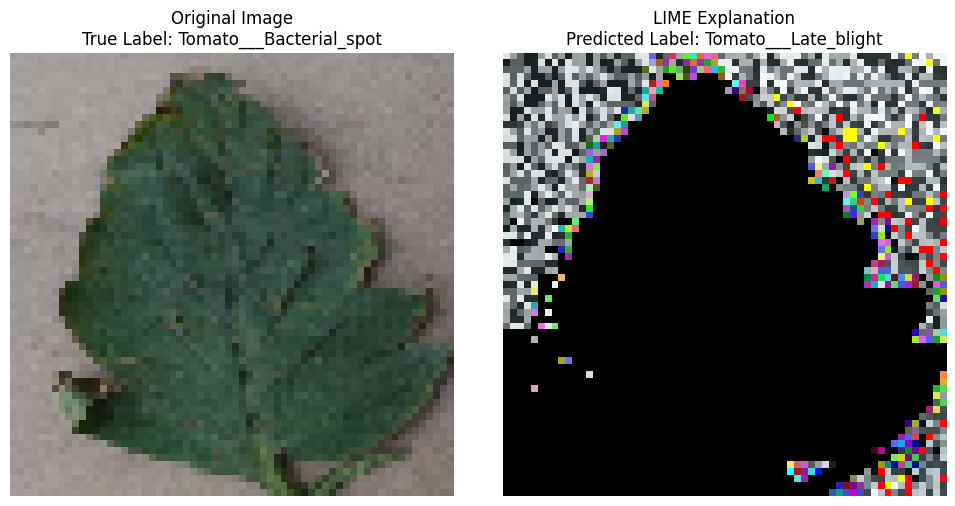

In [29]:
# Get the image and mask for the top prediction
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)

# Convert the explained image to uint8 for display
explained_image = (temp * 255).astype('uint8')

# Get the predicted label name
predicted_label = class_names[explanation.top_labels[0]]

# Display the original image and the explained image
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image_to_explain.astype('uint8'))
plt.title(f"Original Image\nTrue Label: {class_names[true_label]}")
plt.axis('off')

# Explained Image
plt.subplot(1, 2, 2)
plt.imshow(explained_image.astype('uint8'))
plt.title(f"LIME Explanation\nPredicted Label: {predicted_label}")
plt.axis('off')

plt.tight_layout()
plt.show()

# Decode prediction

array([[[224, 229, 232],
        [153, 158, 161],
        [ 93,  98, 101],
        ...,
        [170, 175, 178],
        [239, 244, 247],
        [240, 245, 248]],

       [[ 23,  28,  31],
        [ 90,  95,  98],
        [ 90,  95,  98],
        ...,
        [250, 255,   2],
        [111, 116, 119],
        [240, 245, 248]],

       [[ 90,  95,  98],
        [ 95, 100, 103],
        [ 94,  99, 102],
        ...,
        [243, 248, 251],
        [ 45,  50,  53],
        [ 44,  49,  52]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [129, 140, 144],
        [189, 200, 204],
        [252,   7,  11]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [130, 141, 145],
        [185, 196, 200],
        [ 55,  66,  70]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 59,  70,  74],
        [197, 208, 212],
        [ 64,  75,  79]]], dtype=uint8)
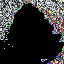

In [30]:
explained_image

In [31]:
# Get true labels and predictions for the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
predictions = np.argmax(model.predict(test_ds), axis=1)

print(f"Shape of true labels: {true_labels.shape}")
print(f"Shape of predictions: {predictions.shape}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Shape of true labels: (1536,)
Shape of predictions: (1536,)


In [32]:
# Identify correctly and incorrectly predicted images
correctly_predicted = (predictions == true_labels)
incorrectly_predicted = ~correctly_predicted

# Get the indices of correctly and incorrectly predicted images
correct_indices = np.where(correctly_predicted)[0]
incorrect_indices = np.where(incorrectly_predicted)[0]

print(f"Number of correctly predicted images: {len(correct_indices)}")
print(f"Number of incorrectly predicted images: {len(incorrect_indices)}")

Number of correctly predicted images: 1490
Number of incorrectly predicted images: 46


In [34]:
# Define the number of images to plot
num_correct_to_plot = 12
num_incorrect_to_plot = 12

# Ensure the number of selected images does not exceed the available number
num_correct_to_plot = min(num_correct_to_plot, len(correct_indices))
num_incorrect_to_plot = min(num_incorrect_to_plot, len(incorrect_indices))

# Randomly select indices
selected_correct_indices = np.random.choice(correct_indices, num_correct_to_plot, replace=False)
selected_incorrect_indices = np.random.choice(incorrect_indices, num_incorrect_to_plot, replace=False)

print(f"Number of correctly predicted images selected for plotting: {len(selected_correct_indices)}")
print(f"Number of incorrectly predicted images selected for plotting: {len(selected_incorrect_indices)}")

Number of correctly predicted images selected for plotting: 12
Number of incorrectly predicted images selected for plotting: 12


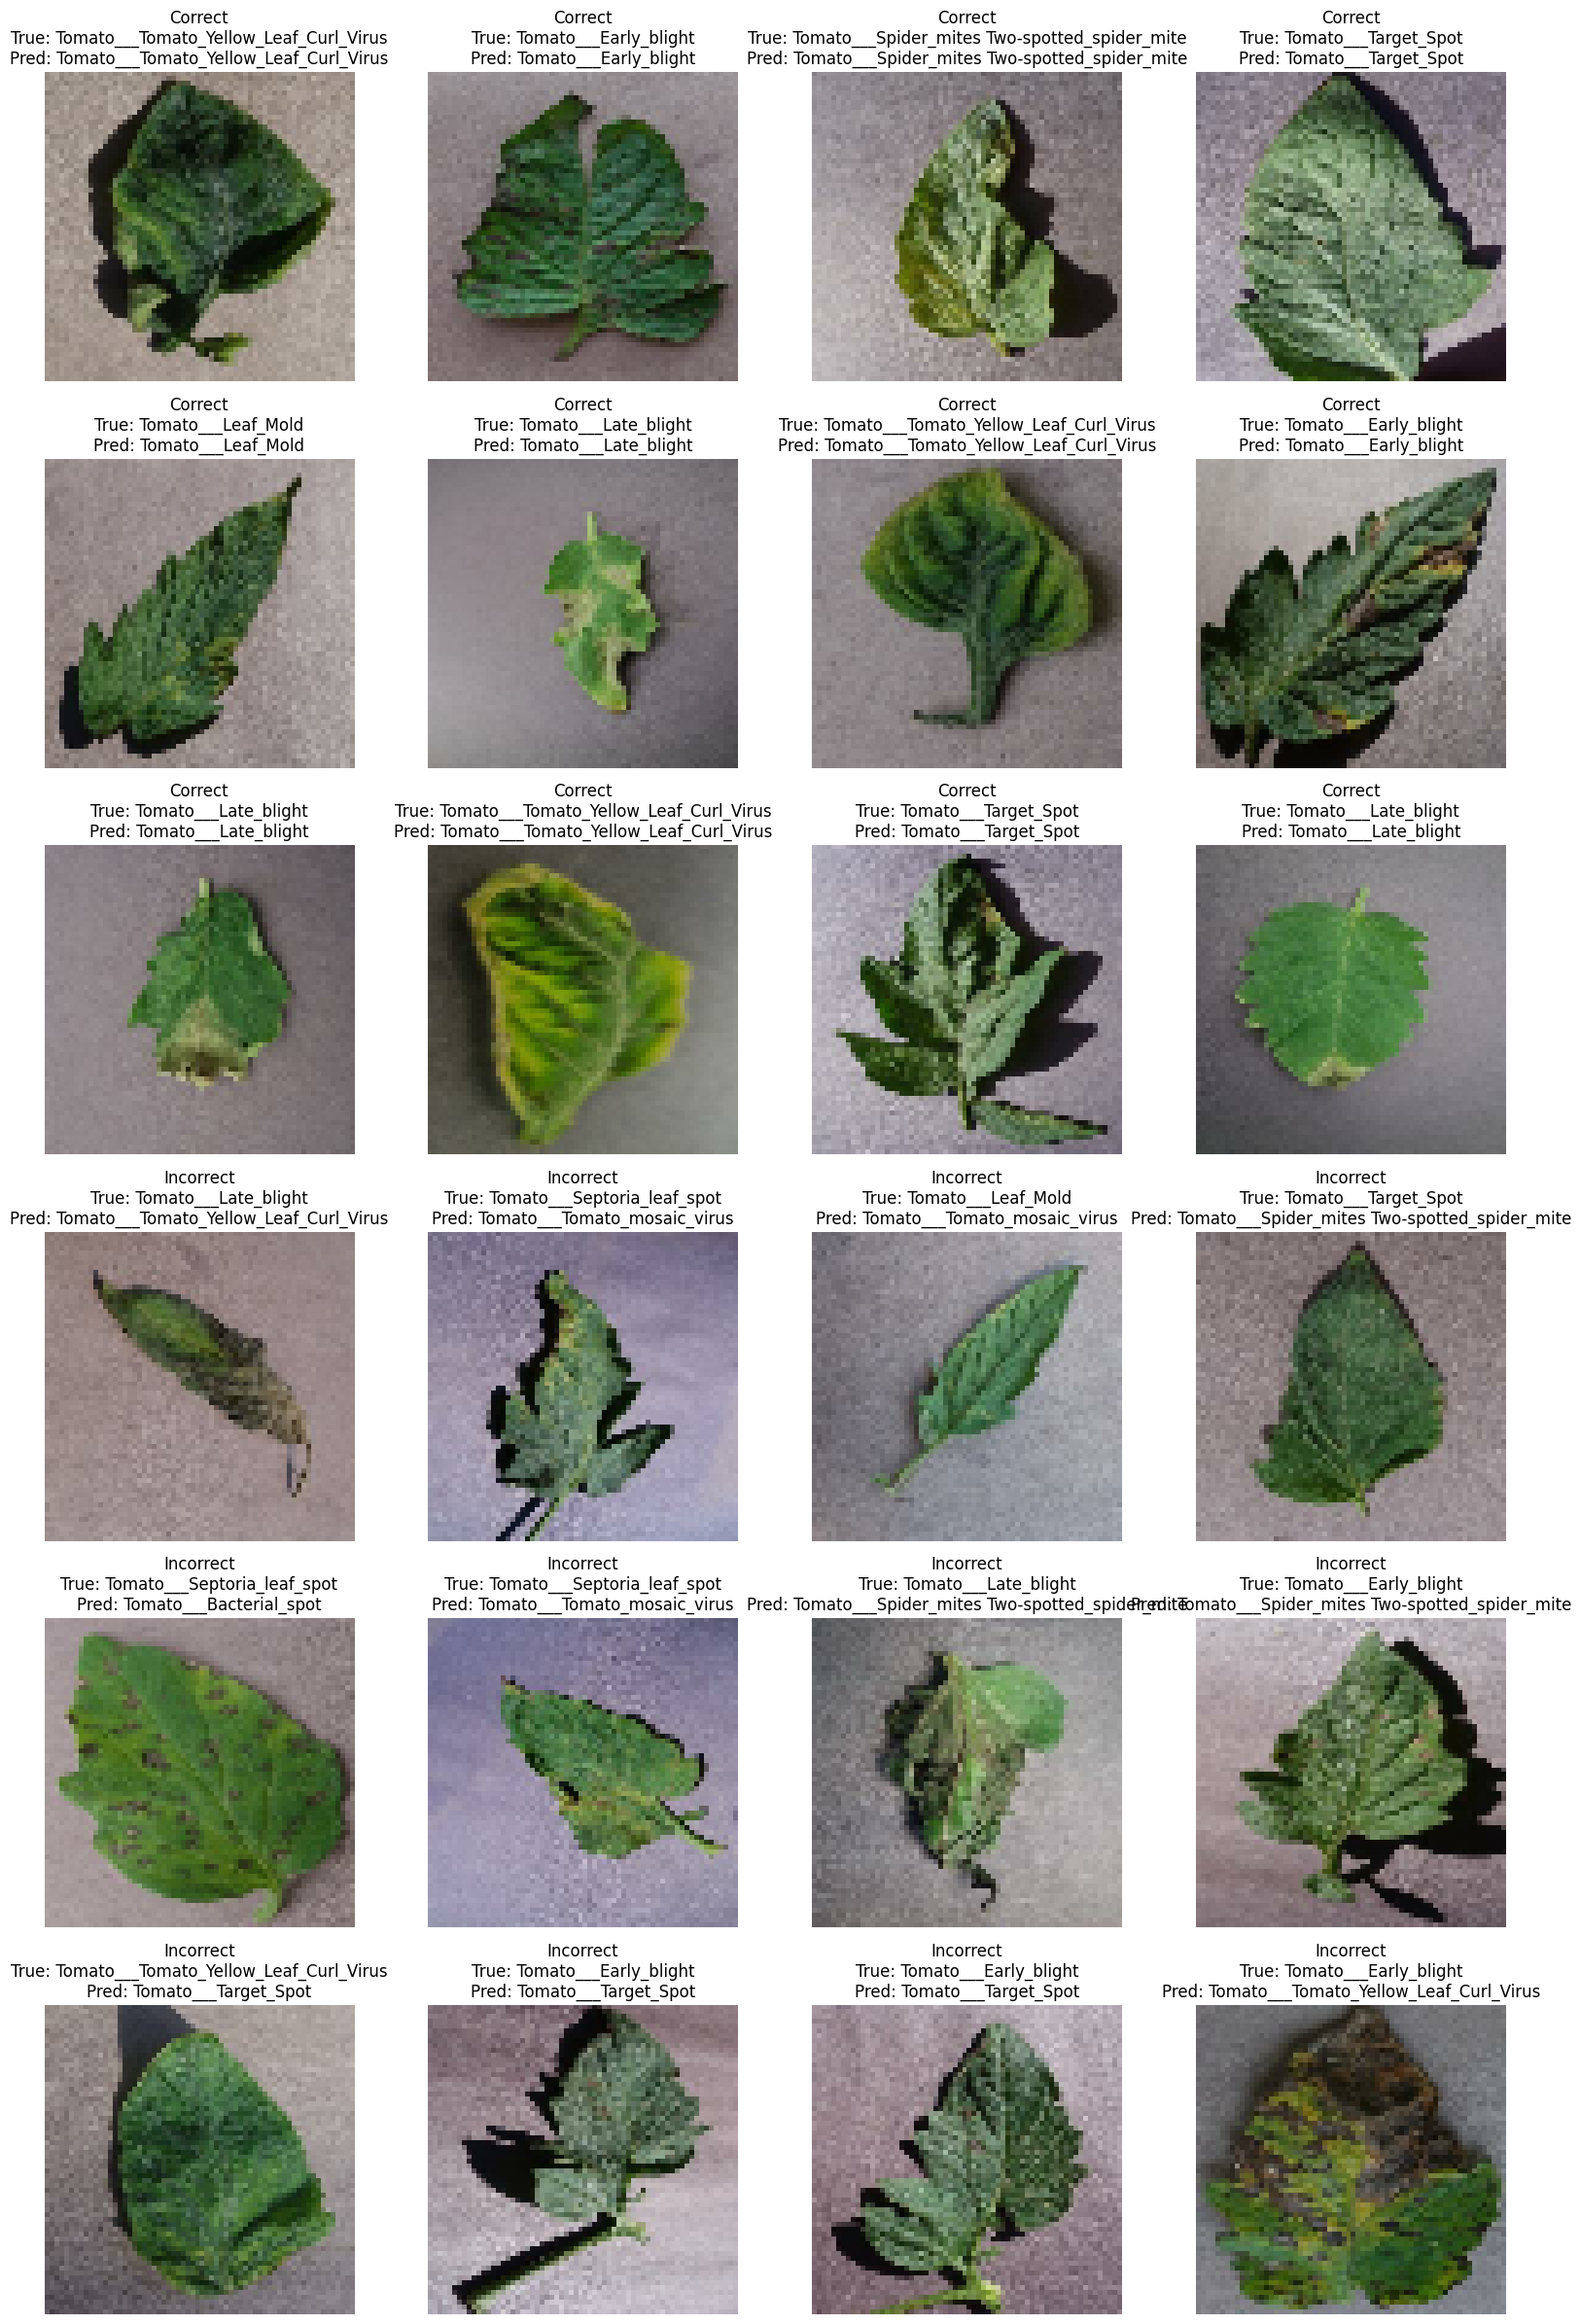

In [35]:
# Create a new figure and axes for plotting
total_images_to_plot = num_correct_to_plot + num_incorrect_to_plot
n_cols = 4 # Adjust based on desired layout
n_rows = (total_images_to_plot + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 4, n_rows * 4))

# Plot correctly predicted images
for i, index in enumerate(selected_correct_indices):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(test_images[index].astype('uint8'))
    plt.title(f"Correct\nTrue: {class_names[true_labels[index]]}\nPred: {class_names[predictions[index]]}")
    plt.axis("off")

# Plot incorrectly predicted images
for i, index in enumerate(selected_incorrect_indices):
    ax = plt.subplot(n_rows, n_cols, num_correct_to_plot + i + 1)
    plt.imshow(test_images[index].astype('uint8'))
    plt.title(f"Incorrect\nTrue: {class_names[true_labels[index]]}\nPred: {class_names[predictions[index]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()